In [10]:
import glob
import os
from typing import List, Sequence, Dict
from collections import namedtuple

import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import boa.acquisition.util as util
from boa.optimization.data import FileHandler, Data


objective_labels = ['cycle', 'avg_power', 'total_area']
save_folder = "../plots/notebook_plots/bayesopt_analysis/"

DataTuple = namedtuple('DataTuple', field_names=['df', 'input_labels', 'output_labels'])

In [18]:
input_labels = {
    "fft": [
            # NB: cache_bandwith is missing!
            'cycle_time',
            'pipelining',
            'cache_size',
            'cache_assoc',
            'cache_hit_latency',
            'cache_line_sz',
            'cache_queue_size',
            'tlb_hit_latency',
            'tlb_miss_latency',
            'tlb_page_size',
            'tlb_entries',
            'tlb_max_outstanding_walks',
            'tlb_assoc',
            'tlb_bandwidth',
            'l2cache_size',
            'enable_l2',
            'pipelined_dma',
            'ignore_cache_flush',
        ],
    "stencil3d": [
            'cycle_time',
            'cache_size',
            'cache_assoc',
            'cache_hit_latency',
            'tlb_hit_latency',
            'tlb_entries',
            'l2cache_size',
        ],
}

output_labels = {
    "fft": [
            'cycle',
            'avg_power',
            'idle_fu_cycles',
            'avg_fu_power',
            'avg_fu_dynamic_power',
            'avg_fu_leakage_power',
            'avg_mem_power',
            'avg_mem_dynamic_power',
            'avg_mem_leakage_power',
            'total_area',
            'fu_area',
            'mem_area',
            'num_double_precision_fp_multipliers',
            'num_double_precision_fp_adders',
            # 'num_trigonometric_units',
            # 'num_bit-wise_operators_32',
            # 'num_shifters_32',
            'num_registers_32',
        ],
    "stencil3d": [
            'cycle',
            'avg_power',
            'fu_power',
            'avg_fu_dynamic_power',
            'avg_fu_leakage_power',
            'avg_mem_power',
            'avg_mem_dynamic_power',
            'avg_mem_leakage_power',
            'total_area',
            'fu_area',
            'mem_area',
            # 'num_sp_multiplier',
            # 'num_sp_adder',
            # 'num_dp_multiplier',
            # 'num_dp_adder',
            # 'num_trig_unit',
            # 'num_multiplier',
            # 'num_adder',
            # 'num_bit_wise',
            # 'num_shifter',
            'num_register',
        ]
}

separators = {
    "fft": " ",
    "stencil3d": "\t"
}

In [19]:
def load_dataset(dataset_path, separator, input_labels, output_labels) -> DataTuple:
    with open(dataset_path) as f:
        df = pd.read_csv(f, sep=separator, dtype=np.float64)

    return DataTuple(df=df[input_labels + output_labels],
                     input_labels=input_labels,
                     output_labels=output_labels)

def load_runs(directory: str) -> List[Data]:
    data_points = []
    for path in glob.glob(os.path.join(directory, '*.json')):
        handler = FileHandler(path=path)
        data_points.append(handler.load())
    return data_points


def calculate_volumes(dfs: Sequence[pd.DataFrame], min_max: pd.DataFrame) -> List[pd.DataFrame]:
    normed_reference = np.array([1, 1, 1])

    volumes_list = []
    for df in dfs:
        points = df[objective_labels]
        normed_points = (points - min_max['min']) / (min_max['max'] - min_max['min'])
        volumes = [(size, util.calculate_hypervolume(points=normed_points.values[:size], reference=normed_reference))
                   for size in range(10, normed_points.shape[0])]
        volumes_list.append(pd.DataFrame(volumes, columns=['size', 'volume']))

    return volumes_list


def summarize(volumes_list):
    frames = pd.concat([d.set_index('size') for d in volumes_list], axis=1)
    return frames.apply(lambda row: pd.Series({'mean': np.mean(row), 'std': np.std(row)}), axis=1).reset_index()

In [36]:
def calculate_statistics(experiment_directories, dataset_path, kind):

    experiment_dict = {}

    # Load experiment JSON files
    for model_name, directory in experiment_directories:
        experiments = load_runs(directory)

        dfs = [pd.DataFrame(data=np.hstack((experiment.input, experiment.output)), 
                            columns=experiment.input_labels + experiment.output_labels)

               for experiment in experiments]

        base_name = os.path.basename(directory)
        experiment_dict[model_name] = dfs

    # Load the dataset
    dataset = load_dataset(dataset_path=dataset_path, 
                           separator=separators[kind], 
                           input_labels=input_labels[kind],
                           output_labels=output_labels[kind])
    min_max = dataset.df[objective_labels].apply(lambda column: pd.Series({
        'min': column.min(),
        'max': column.max()
    })).transpose()

    # Calculate summary statistics for the dataset
    volumes_dict = {key: calculate_volumes(experiment, min_max) for key, experiment in experiment_dict.items()}
    summary_dict = {key: summarize(volume) for key, volume in volumes_dict.items()}
    
    return experiment_dict, volumes_dict, summary_dict

In [13]:
def plot_bayesopt_experiment(experiment_dict, volumes_dict, summary_dict, kind):
    
    
    label_dict = {
        'random': 'Random',
        'ff-gp': 'FF-GP',
        'gp': 'FF-GP',
        'gpar': 'GPAR',
        'mf-gpar': 'MF-GPAR',
        'mf-gpar_3': 'MF-GPAR-3',
        'mf-gpar_5': 'MF-GPAR-5',
    }

    color_dict = {
        'random': 'C0',
        'gp': 'C1',
        'ff-gp': 'C1',
        'gpar': 'C2',
        'mf-gpar': 'C3',
        'mf-gpar_3': 'C4',
        'mf-gpar_5': 'C5',
    }

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

    for name, volumes_list in volumes_dict.items():
        for volumes in volumes_list:
            ax.plot(
                volumes['size'],
                volumes['volume'],
                color=color_dict[name],
                alpha=0.3,
                linestyle='dashed',
                zorder=-1,
                label='_nolegend_',
            )

    for name, summary in summary_dict.items():
        ax.fill_between(
            x=summary['size'],
            y1=summary['mean'] + 2 * summary['std'],
            y2=summary['mean'] - 2 * summary['std'],
            color=color_dict[name],
            alpha=0.2,
            zorder=-2,
        )

    ordered_names = ['random', 'ff-gp', 'gpar', 'mf-gpar', 'mf-gpar_3', 'mf-gpar_5']

    for name in ordered_names:
        if name not in summary_dict:
            continue

        ax.plot(summary_dict[name]['size'],
                summary_dict[name]['mean'],
                label=label_dict[name],
                linestyle='solid',
                linewidth=3,
                color=color_dict[name],
                zorder=0)

    ax.legend(loc='lower right', prop={'size': 12})

    ax.set_ylabel('Hypervolume', fontsize=12)
    ax.set_xlabel('Evaluations', fontsize=12)
    
    ax.set_xlim([10, 120])

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    fig.show()
    fig.savefig(f'{save_folder}/{kind}/bayesopt-{current_time}.png')


In [14]:
def comparison_plot(old_experiment_dict,                  
                    old_volumes_dict, 
                    old_summaries_dict, 
                    
                    new_experiment_dict,
                    new_volumes_dict, 
                    new_summaries_dict, 
                    
                    kind):
    
    names_map = {
        'random': 0,
        'gp': 1,
        'ff-gp': 1,
        'gpar': 2,
        'mf-gpar': 3,
        'mf-gpar_3': 3,
        'mf-gpar_5': 3,
    }
    
    label_dict = {
        'random': 'Random',
        'gp': 'FF-GP',
        'ff-gp': 'FF-GP',
        'gpar': 'GPAR',
        'mf-gpar': 'MF-GPAR',
        'mf-gpar_3': 'MF-GPAR-3',
        'mf-gpar_5': 'MF-GPAR-5',
    }

    old_color_dict = {
        'random': 'C0',
        'gp': 'C1',
        'ff-gp': 'C1',
        'gpar': 'C2',
        'mf-gpar': 'C3',
        'mf-gpar_3': 'C4',
        'mf-gpar_5': 'C5',
    }

    new_color_dict = {
        'random': 'C1',
        'ff-gp': 'C2',
        'gpar': 'C3',
        'mf-gpar': 'C4',
        'mf-gpar_3': 'C5',
        'mf-gpar_5': 'C0',
    }
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    
    axes = axes.flatten()
    
    for name, index in names_map.items():
        if name in old_volumes_dict:
            for volumes in old_volumes_dict[name]:
                axes[index].plot(
                    volumes['size'],
                    volumes['volume'],
                    color=old_color_dict[name],
                    alpha=0.3,
                    linestyle='dashed',
                    zorder=-1,
                    label='_nolegend_',
                )
                
            axes[index].fill_between(
                x=old_summaries_dict[name]['size'],
                y1=old_summaries_dict[name]['mean'] + 2 * old_summaries_dict[name]['std'],
                y2=old_summaries_dict[name]['mean'] - 2 * old_summaries_dict[name]['std'],
                color=old_color_dict[name],
                alpha=0.2,
                zorder=-2,
            )
            
            axes[index].plot(old_summaries_dict[name]['size'],
                old_summaries_dict[name]['mean'],
                label=f"Old {label_dict[name]}",
                linestyle='solid',
                linewidth=3,
                color=old_color_dict[name],
                zorder=0)
                
        if name in new_volumes_dict:    
            for volumes in new_volumes_dict[name]:
                axes[index].plot(
                    volumes['size'],
                    volumes['volume'],
                    color=new_color_dict[name],
                    alpha=0.3,
                    linestyle='dashed',
                    zorder=-1,
                    label='_nolegend_',
                )
                
            axes[index].fill_between(
                x=new_summaries_dict[name]['size'],
                y1=new_summaries_dict[name]['mean'] + 2 * new_summaries_dict[name]['std'],
                y2=new_summaries_dict[name]['mean'] - 2 * new_summaries_dict[name]['std'],
                color=new_color_dict[name],
                alpha=0.2,
                zorder=-2,
            )
            
            axes[index].plot(new_summaries_dict[name]['size'],
                new_summaries_dict[name]['mean'],
                label=f"New {label_dict[name]}",
                linestyle='solid',
                linewidth=3,
                color=new_color_dict[name],
                zorder=0)
            
        axes[index].set_title(label_dict[name])
        
        
        axes[index].legend(loc='lower right', prop={'size': 12})

        axes[index].set_ylabel('Hypervolume', fontsize=12)
        axes[index].set_xlabel('Evaluations', fontsize=12)

        axes[index].set_xlim([10, 120])

    fig.show()
    fig.savefig(f'{save_folder}/{kind}/bayesopt_comparisons.png')

In [15]:
old_fft_bayesopt_dir = "../../data/bayesopt-old/data/fft/bayesopt/"
old_stencil3d_bayesopt_dir = "../../data/bayesopt-old/data/stencil3d/bayesopt/"

In [16]:
fft_bayesopt_dir = "../logs-old/fft/bayesopt"
fft_dataset_path = "../resources/fft_dataset.csv"

stencil3d_bayesopt_dir = "../logs-old/stencil3d/bayesopt"
stencil3d_dataset_path = "../resources/stencil3d_dataset.csv"

gemm_bayesopt_dir = "../logs-old/gemm/bayesopt"
gemm_dataset_path = "../resources/gemm_dataset.csv"

In [46]:
!ls ../logs/fft/bayesopt/random-10/20200326-135227

0.json	1.json	2.json	3.json	4.json


In [47]:
old_fft_experiment_directories = [
    ("ff-gp", f"{old_fft_bayesopt_dir}/ff-gp"),
    ("gpar", f"{old_fft_bayesopt_dir}/gpar"),
    ("mf-gpar", f"{old_fft_bayesopt_dir}/mf-gpar"),
    ("random", f"{old_fft_bayesopt_dir}/random"),
]

fft_experiment_directories = [
    ("ff-gp", "../logs/fft/bayesopt/ff-gp/20200325-214906"),
    ("gpar", "../logs/fft/bayesopt/gpar/20200325-214756"),
    ("random", "../logs/fft/bayesopt/random-10/20200326-135227")
]

In [26]:
old_fft_summaries = calculate_statistics(old_fft_experiment_directories,
                                         dataset_path=fft_dataset_path,
                                         kind="fft")

In [48]:
new_fft_summaries = calculate_statistics(fft_experiment_directories,
                                         dataset_path=fft_dataset_path,
                                         kind="fft")

In [56]:
old_stencil3d_summaries = calculate_statistics(experiments_log_dir=old_stencil3d_bayesopt_dir,
                                               dataset_path=stencil3d_dataset_path,
                                               kind="stencil3d")

In [97]:
new_stencil3d_summaries = calculate_statistics(experiments_log_dir=stencil3d_bayesopt_dir,
                                               dataset_path=stencil3d_dataset_path,
                                               kind="stencil3d")

In [107]:
new_gemm_summaries = calculate_statistics(experiments_log_dir=gemm_bayesopt_dir,
                                               dataset_path=gemm_dataset_path,
                                               kind="gemm")

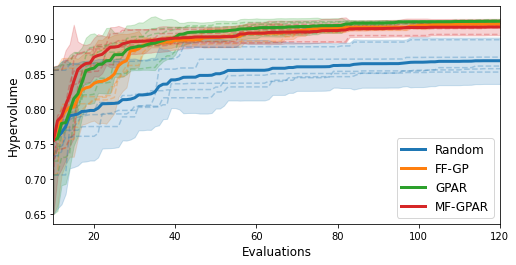

In [34]:
plot_bayesopt_experiment(*old_fft_summaries, kind="fft")

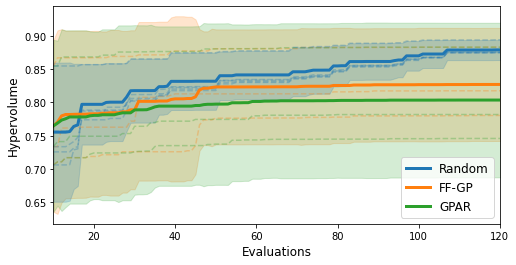

In [49]:
plot_bayesopt_experiment(*new_fft_summaries, kind="fft")

/scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


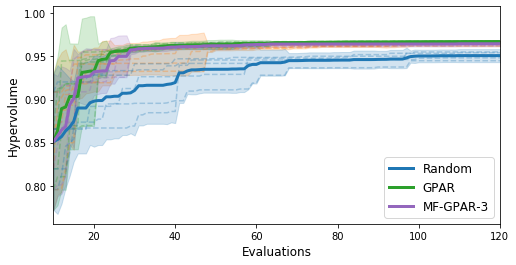

In [64]:
plot_bayesopt_experiment(*old_stencil3d_summaries, kind="stencil3d")

/scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


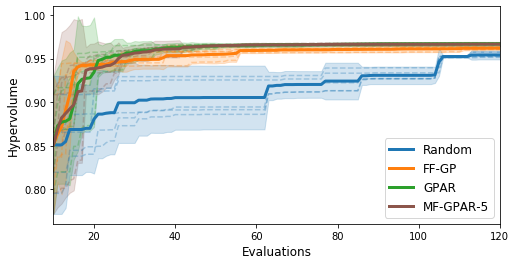

In [100]:
plot_bayesopt_experiment(*new_stencil3d_summaries, kind="stencil3d")

/scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


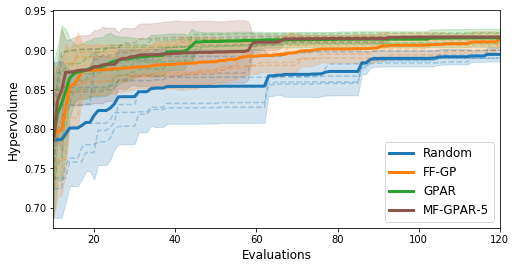

In [108]:
plot_bayesopt_experiment(*new_gemm_summaries, kind="gemm")

No handles with labels found to put in legend.
/scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:123: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


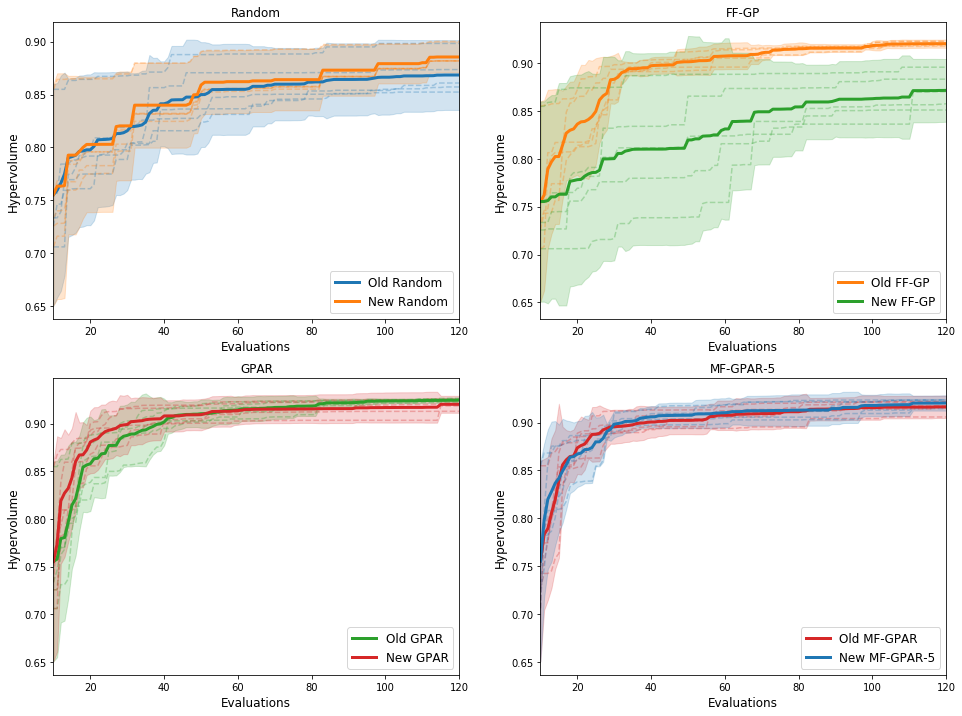

In [102]:
comparison_plot(*(old_fft_summaries + new_fft_summaries), kind="fft")

No handles with labels found to put in legend.
/scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:123: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


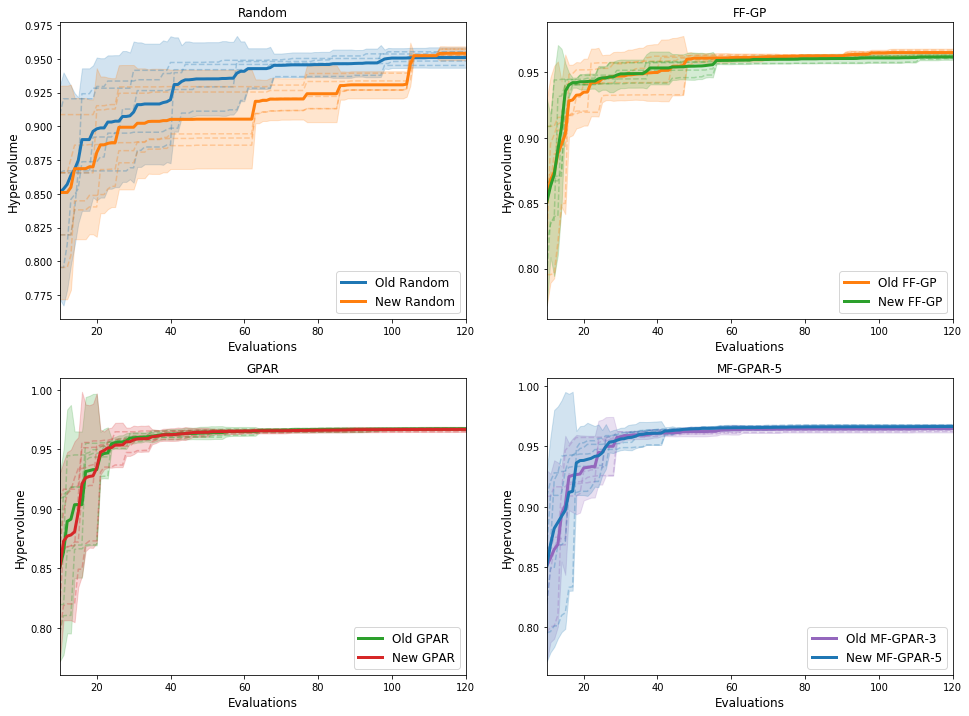

In [104]:
comparison_plot(*(old_stencil3d_summaries + new_stencil3d_summaries), kind="stencil3d")